<a href="https://colab.research.google.com/github/amirhoseinaghaei/Image-Captioning-/blob/main/Image_Captioning_For_Flicker_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
import os
import numpy as np 
import pickle
import tensorflow as tf
from tensorflow.keras import models , Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tqdm import tqdm 
# from tensorflow.keras.preprocessing.text import Tokenizer 
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Conv2D , MaxPooling2D   , Flatten
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 

## Getting dataset from google drive

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive/')
BASE_DIR = "gdrive/MyDrive/Flicker_Dataset"
WORKING_DIR  = "gdrive/MyDrive/Image_Captioning_Project "

Mounted at /content/gdrive/


## Load pretrained VGG16 model 

In [2]:
# Load VGG16 model 
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
model.summary()

553467096/553467096 [==============================] - 16s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

## Load Flicker dataset images and extract the features with VGG16 model 

In [6]:
# Loading the flicker-dataset images and extracting featueres
from tqdm import tqdm
features = {}
img_list = []
directory = os.path.join(BASE_DIR, "Images")
with open(os.path.join(WORKING_DIR , "features.pkl"), "rb") as f:
    features = pickle.load(f)
for img_name in tqdm(os.listdir(directory)):
  image_path = directory  + "/" + img_name
  image = load_img(image_path , target_size= (224,224))
  image = img_to_array(image) 
  image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
  feature = model.predict(image)
  # img_list.append(image)
  image_id = img_name.split(".")[0]
  features[image_id]  = feature


  0%|          | 0/8101 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 1/8101 [00:00<15:12,  8.88it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 3/8101 [00:00<13:56,  9.68it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 4/8101 [00:00<13:57,  9.67it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 5/8101 [00:01<37:58,  3.55it/s]


KeyboardInterrupt: ignored

## Save the extracted features 

In [ ]:
# saving features dictionary in pkl file 
import pickle
pickle.dump(features , open(os.path.join(WORKING_DIR , "features.pkl"), "wb"))

## Loading Captions for each image

In [10]:
with open(os.path.join(BASE_DIR, "captions.txt"), 'r') as f: 
  next(f)
  captions = f.read()

In [11]:
mapping = {}
line = captions.split("\n")
for i in line:
  splitted = i.split(",")
  if len(line) < 2:
    continue
  img_id = splitted[0].split(".")[0]
  # print(splitted[1])
  caption = splitted[1:]
  caption = " ".join(caption)
  if img_id not in mapping.keys():
     mapping[img_id] = []
  # print(image_id + ": " + caption)
  mapping[img_id].append(caption)


## Visualizing 10 images with their captions


  0%|          | 9/8101 [00:00<03:11, 42.30it/s]


Image : 386655611_1329495f97.jpg
386655611_1329495f97.jpg's captions are as below:
['A black dog carries a huge stick in its mouth .', 'A black dog is carrying a huge stick whilst walking in the snow .', '"A dog carries a huge   snow covered stick ."', 'A dog carries a very large tree branch in the snow .', 'The brown and white dog carries a very large stick across the snow .', 'A black dog carries a huge stick in its mouth .', 'A black dog is carrying a huge stick whilst walking in the snow .', '"A dog carries a huge   snow covered stick ."', 'A dog carries a very large tree branch in the snow .', 'The brown and white dog carries a very large stick across the snow .']

Image : 384465575_31294122c0.jpg
384465575_31294122c0.jpg's captions are as below:
['A man and a woman are biking on a sunny day .', 'Man and woman cyclists ride pass signs on rural road .', 'Two bicyclists ride down a hill .', 'Two friends bike down a hill .', 'Two people are riding their bicycles on a dirt road', 'A 

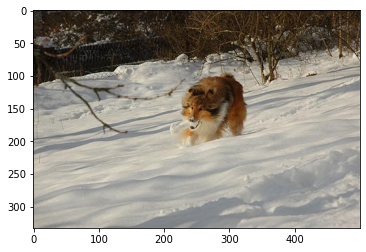

In [14]:
i = 0 
for img_name in tqdm(os.listdir(directory)):
  i += 1
  image_path = directory + "/" + img_name 
  image = mpimg.imread(image_path)
  print(f"\nImage : {img_name}")
  plt.imshow(image)
  print(f"{img_name}'s captions are as below:")
  image_id = img_name.split(".")[0]
  print(mapping[image_id])
  if i == 10: 
    break

## Defining the model

In [ ]:
from tensorflow.python.keras.layers.merge import Add
from tensorflow.python.ops.gen_array_ops import InplaceAdd
from keras.backend import conv2d

from keras import optimizers
from tensorflow.python.ops.nn_ops import relu
def Build_CNN_FeatureExtractor(vocab_size):
      input1 = Input(shape=(224,224,3))
      conv1 = Conv2D(64, (3, 3), activation= tf.nn.relu, padding="same")(input1)
      conv2 = Conv2D(64, (3, 3), activation= tf.nn.relu, padding="same")(conv1)
      max1 =  MaxPooling2D((2,2), (2,2))(conv2)
      conv3 = Conv2D(128, (3, 3), activation= tf.nn.relu, padding="same")(max1)
      conv4 = Conv2D(128, (3, 3), activation= tf.nn.relu, padding="same")(conv3)
      max2 =  MaxPooling2D((2,2), (2,2))(conv4)
      conv5 = Conv2D(256, (3, 3), activation= tf.nn.relu, padding="same")(max2)
      conv6 = Conv2D(256, (3, 3), activation= tf.nn.relu, padding="same")(conv5)
      conv7 = Conv2D(256, (3, 3), activation= tf.nn.relu, padding="same")(conv6)
      max3 =  MaxPooling2D((2,2), (2,2))(conv7)
      conv8 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(max3)
      conv9 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv8)
      conv10 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv9)
      max4 =  MaxPooling2D((2,2), (2,2))(conv10)
      conv11 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(max4)
      conv12 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv11)
      conv13 = Conv2D(512, (3, 3), activation= tf.nn.relu, padding="same")(conv12)
      max5 =  MaxPooling2D((2,2), (2,2))(conv13)
      flatten = Flatten()(max5)
      dense1 = Dense(4096, activation = tf.nn.relu)(flatten)
      dropout1 = Dropout(0.4)(dense1)
      dense2 = Dense(4096)(dropout1)
      dense3 = Dense(256)(dense2)
      input2 = Input(shape = (35,))
      embedding = Embedding(input_dim = vocab_size, output_dim = 256)(input2)
      dropout2 = Dropout(0.4)(embedding)
      lstm = LSTM(256)(dropout2)
      added = add([dense3, lstm])
      dense4 = Dense(256 , activation = tf.nn.relu)(added)
      output = Dense(vocab_size, activation = tf.nn.softmax)(dense4)
      model = Model(inputs = [input1 , input2], outputs = output)
      return model
 
vocab_size = 8600
model = Build_CNN_FeatureExtractor(vocab_size)
optimizer = tf.optimizers.Adam()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy" , metrics = ["Accuracy"] )
model.summary()

## Plotting the model

In [ ]:
plot_model(model= model)